In [2]:
pip install getFamaFrenchFactors --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff

# 애플 과거 주가 데이터 다운로드

In [7]:
ticker = 'AAPL'

start = '2000-01-01'
end = '2022-12-28'

stock_data = yf.download(ticker, start, end)

#주가 수익률
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = 'Month_Rtn'
stock_returns.index = pd.to_datetime(stock_returns.index).date

[*********************100%***********************]  1 of 1 completed


In [8]:
stock_returns

2000-02-29    0.104820
2000-03-31    0.184842
2000-04-30   -0.086517
2000-05-31   -0.322922
2000-06-30    0.247024
                ...   
2022-08-31   -0.031208
2022-09-30   -0.120977
2022-10-31    0.109551
2022-11-30   -0.033027
2022-12-31   -0.121597
Name: Month_Rtn, Length: 275, dtype: float64

# 파마-프렌치 3 팩터 데이터 다운로드

In [12]:
# 파마-프렌치 3 팩터 데이터 다운로드
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly = ff3_monthly.rename(columns={'date_ff_factors':'Date'})
ff3_monthly = ff3_monthly.set_index('Date')
ff3_monthly.index = pd.to_datetime(ff3_monthly.index).date

In [13]:
ff3_monthly

,Mkt-RF,SMB,HML,RF
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008
2022-08-31,-0.0377,0.0139,0.0031,0.0019
2022-09-30,-0.0935,-0.0082,0.0003,0.0019


In [14]:
# 팩터 데이터와 주가 데이터 병합
ff_data = pd.concat([ff3_monthly,stock_returns],axis=1,join='inner')

In [15]:
ff_data

,Mkt-RF,SMB,HML,RF,Month_Rtn
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.104820
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.184842
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086517
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,-0.322922
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.247024
...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0377,0.0139,0.0031,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0003,0.0019,-0.120977


In [16]:
# ff_data 데이터프레임 칼럼 이름 변경
ff_data.columns = ['beta','size','value','rf','ret']
ff_data

,beta,size,value,rf,ret
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.104820
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.184842
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086517
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,-0.322922
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.247024
...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0377,0.0139,0.0031,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0003,0.0019,-0.120977


# 파마-프렌치 3팩터 모델로 주가 선형 회귀 분석

In [18]:
# 회귀 분석 설명 변수 : 3팩터
x = ff_data[['beta','size','value']]

# 회귀 분석 종속 변수 : 애플의 무위험 초과 수익률
y = ff_data['ret'] - ff_data['rf']

ff_model = sm.OLS(y,x).fit()

print(ff_model.summary())

# 베타 계수 할당
b1, b2, b3 = ff_model.params

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.370
Model:                            OLS   Adj. R-squared (uncentered):              0.363
Method:                 Least Squares   F-statistic:                              52.89
Date:                Wed, 28 Dec 2022   Prob (F-statistic):                    6.34e-27
Time:                        12:06:11   Log-Likelihood:                          262.27
No. Observations:                 273   AIC:                                     -518.5
Df Residuals:                     270   BIC:                                     -507.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [19]:
b1, b2, b3

(1.3851921290264524, 0.10524492829174113, -0.7461997607614556)

In [20]:
# 무위험 수익률
rf = ff_data['rf'].mean()

# 시장 위험 프리미엄
market_premium = ff_data['beta'].mean()

# 사이즈 프리미엄
size_premium = ff_data['size'].mean()

# 밸류 프리미엄
value_premium = ff_data['value'].mean()

In [21]:
# 팩터를 활용한 기대수익률 계산

# 월간 기대수익률
expected_monthly_return = rf + (b1 * market_premium) + (b2 * size_premium) + (b3 * value_premium)

# 연간 기대수익률
expected_yearly_return = expected_monthly_return * 12

# 기대수익률 출력
print('Expected Yearly Return: ' + str(expected_yearly_return))

Expected Yearly Return: 0.08268219665285301


# 시간 가변적 베타 (Time-Varying Beta)

In [22]:
# RollingOLS 임포트
from statsmodels.regression.rolling import RollingOLS

In [25]:
# 3-팩터 롤링 베타 추출
betas = RollingOLS.from_formula('ret ~ beta + size + value',data=ff_data, window=36).fit().params

In [26]:
betas

,Intercept,beta,size,value
2000-02-29,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN
2000-06-30,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-06-30,0.022748,1.292452,-0.598420,-0.453837
2022-07-31,0.022798,1.314894,-0.558703,-0.472186
2022-08-31,0.024304,1.304920,-0.587338,-0.493836
2022-09-30,0.021797,1.320926,-0.566632,-0.534356


<AxesSubplot: >

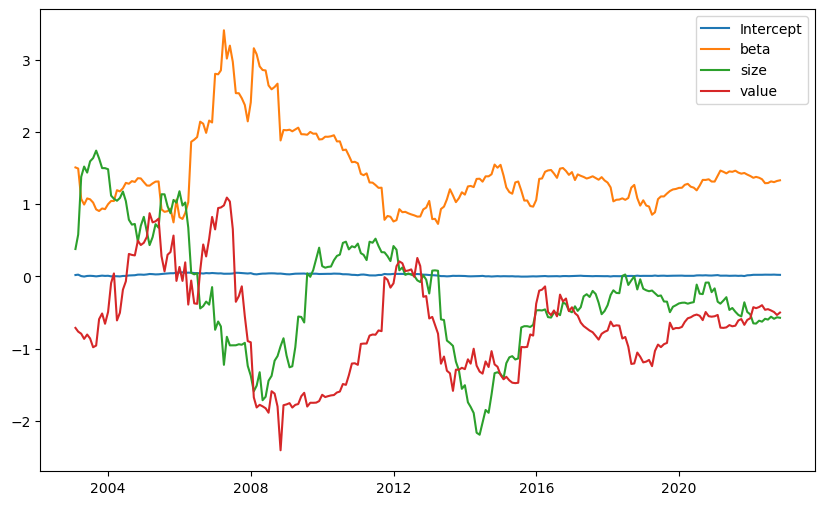

In [27]:
# 팩터 계수 그래프
betas.dropna().plot(figsize=(10,6))